In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from numba import jit, float64, int64

In [2]:
@jit(nopython=True)
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[0]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [3]:
data_df = pd.read_csv('../../../_data/Yang2024.csv', index_col=0)

data_df['choice'] = data_df['choice'].map({1:0, 2:1})

min_rt = data_df.groupby(by='sbj')['rt'].min()
data_df['sbj'] -= 1

tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(data_df[['rt', 'Right', 'sbj']])
X_train = np.asarray(data_df[["o1_a1_val", "o1_a2_val", "o2_a1_val", "o2_a2_val",
                              "o1_a1_gaze", "o1_a2_gaze", "o2_a1_gaze", "o2_a2_gaze"]])

obs_test = np.asarray(data_df[['rt', 'Right', 'sbj']])
X_test = np.asarray(data_df[["o1_a1_val", "o1_a2_val", "o2_a1_val", "o2_a2_val",
                             "o1_a1_gaze", "o1_a2_gaze", "o2_a1_gaze", "o2_a2_gaze"]])

print(X_train.shape, X_test.shape)

(9731, 8) (9731, 8)


In [4]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):

    sbj_indices = tf.cast(data[:, 2], tf.int32)

    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))

    ll1 = (1 - data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 0]))

    return -2*tf.reduce_sum(tf.math.log(tf.maximum(ll1 + ll2, 1e-14)), axis=-1)

In [5]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [6]:
layers_neuron = [10, 10, 8, 5]
input_shape = 8
output_shape = 2
activation = 'tanh'
n_sbj = data_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                90        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 96        
                                                                 
Total params: 429 (1.68 KB)
Trainable params: 429 (1.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [7]:
sbj_indices = tf.cast(obs_train[:, 2], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [8]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=2500)

Epoch 1/2500
1/1 [==============================] - 1s 577ms/step - loss: 46893.1875
Epoch 2/2500
1/1 [==============================] - 0s 3ms/step - loss: 46699.5859
Epoch 3/2500
1/1 [==============================] - 0s 4ms/step - loss: 46566.1328
Epoch 4/2500
1/1 [==============================] - 0s 4ms/step - loss: 46457.2812
Epoch 5/2500
1/1 [==============================] - 0s 5ms/step - loss: 46362.2500
Epoch 6/2500
1/1 [==============================] - 0s 4ms/step - loss: 46276.1250
Epoch 7/2500
1/1 [==============================] - 0s 4ms/step - loss: 46196.0938
Epoch 8/2500
1/1 [==============================] - 0s 4ms/step - loss: 46120.4336
Epoch 9/2500
1/1 [==============================] - 0s 4ms/step - loss: 46048.0312
Epoch 10/2500
1/1 [==============================] - 0s 4ms/step - loss: 45978.1953
Epoch 11/2500
1/1 [==============================] - 0s 4ms/step - loss: 45910.4609
Epoch 12/2500
1/1 [==============================] - 0s 3ms/step - loss: 45844.4922

1/1 [==============================] - 0s 4ms/step - loss: 41450.5391
Epoch 99/2500
1/1 [==============================] - 0s 5ms/step - loss: 41410.4062
Epoch 100/2500
1/1 [==============================] - 0s 5ms/step - loss: 41370.5352
Epoch 101/2500
1/1 [==============================] - 0s 4ms/step - loss: 41330.9414
Epoch 102/2500
1/1 [==============================] - 0s 4ms/step - loss: 41291.6133
Epoch 103/2500
1/1 [==============================] - 0s 5ms/step - loss: 41252.5508
Epoch 104/2500
1/1 [==============================] - 0s 5ms/step - loss: 41213.7500
Epoch 105/2500
1/1 [==============================] - 0s 4ms/step - loss: 41175.2109
Epoch 106/2500
1/1 [==============================] - 0s 4ms/step - loss: 41136.9219
Epoch 107/2500
1/1 [==============================] - 0s 4ms/step - loss: 41098.8984
Epoch 108/2500
1/1 [==============================] - 0s 4ms/step - loss: 41061.1250
Epoch 109/2500
1/1 [==============================] - 0s 4ms/step - loss: 41023.6

1/1 [==============================] - 0s 5ms/step - loss: 38525.3516
Epoch 195/2500
1/1 [==============================] - 0s 4ms/step - loss: 38501.9531
Epoch 196/2500
1/1 [==============================] - 0s 4ms/step - loss: 38478.6484
Epoch 197/2500
1/1 [==============================] - 0s 4ms/step - loss: 38455.4531
Epoch 198/2500
1/1 [==============================] - 0s 4ms/step - loss: 38432.3516
Epoch 199/2500
1/1 [==============================] - 0s 5ms/step - loss: 38409.3477
Epoch 200/2500
1/1 [==============================] - 0s 4ms/step - loss: 38386.4453
Epoch 201/2500
1/1 [==============================] - 0s 5ms/step - loss: 38363.6328
Epoch 202/2500
1/1 [==============================] - 0s 4ms/step - loss: 38340.9180
Epoch 203/2500
1/1 [==============================] - 0s 4ms/step - loss: 38318.2969
Epoch 204/2500
1/1 [==============================] - 0s 4ms/step - loss: 38295.7656
Epoch 205/2500
1/1 [==============================] - 0s 4ms/step - loss: 38273.

1/1 [==============================] - 0s 5ms/step - loss: 36561.9805
Epoch 291/2500
1/1 [==============================] - 0s 5ms/step - loss: 36542.0859
Epoch 292/2500
1/1 [==============================] - 0s 4ms/step - loss: 36522.0938
Epoch 293/2500
1/1 [==============================] - 0s 4ms/step - loss: 36502.0078
Epoch 294/2500
1/1 [==============================] - 0s 5ms/step - loss: 36481.8047
Epoch 295/2500
1/1 [==============================] - 0s 4ms/step - loss: 36461.4766
Epoch 296/2500
1/1 [==============================] - 0s 4ms/step - loss: 36441.0000
Epoch 297/2500
1/1 [==============================] - 0s 4ms/step - loss: 36420.3672
Epoch 298/2500
1/1 [==============================] - 0s 4ms/step - loss: 36399.5547
Epoch 299/2500
1/1 [==============================] - 0s 4ms/step - loss: 36378.5469
Epoch 300/2500
1/1 [==============================] - 0s 4ms/step - loss: 36357.3086
Epoch 301/2500
1/1 [==============================] - 0s 4ms/step - loss: 36335.

1/1 [==============================] - 0s 4ms/step - loss: 33387.9258
Epoch 387/2500
1/1 [==============================] - 0s 4ms/step - loss: 33349.5469
Epoch 388/2500
1/1 [==============================] - 0s 5ms/step - loss: 33311.2070
Epoch 389/2500
1/1 [==============================] - 0s 4ms/step - loss: 33272.9062
Epoch 390/2500
1/1 [==============================] - 0s 4ms/step - loss: 33234.6445
Epoch 391/2500
1/1 [==============================] - 0s 4ms/step - loss: 33196.4297
Epoch 392/2500
1/1 [==============================] - 0s 4ms/step - loss: 33158.2734
Epoch 393/2500
1/1 [==============================] - 0s 4ms/step - loss: 33120.1758
Epoch 394/2500
1/1 [==============================] - 0s 4ms/step - loss: 33082.1523
Epoch 395/2500
1/1 [==============================] - 0s 5ms/step - loss: 33044.2148
Epoch 396/2500
1/1 [==============================] - 0s 5ms/step - loss: 33006.3906
Epoch 397/2500
1/1 [==============================] - 0s 4ms/step - loss: 32968.

1/1 [==============================] - 0s 4ms/step - loss: 30265.6172
Epoch 483/2500
1/1 [==============================] - 0s 4ms/step - loss: 30238.1816
Epoch 484/2500
1/1 [==============================] - 0s 5ms/step - loss: 30210.7266
Epoch 485/2500
1/1 [==============================] - 0s 4ms/step - loss: 30183.4414
Epoch 486/2500
1/1 [==============================] - 0s 4ms/step - loss: 30156.1309
Epoch 487/2500
1/1 [==============================] - 0s 4ms/step - loss: 30128.9941
Epoch 488/2500
1/1 [==============================] - 0s 4ms/step - loss: 30101.8281
Epoch 489/2500
1/1 [==============================] - 0s 4ms/step - loss: 30074.8379
Epoch 490/2500
1/1 [==============================] - 0s 4ms/step - loss: 30047.8164
Epoch 491/2500
1/1 [==============================] - 0s 4ms/step - loss: 30020.9727
Epoch 492/2500
1/1 [==============================] - 0s 4ms/step - loss: 29994.0898
Epoch 493/2500
1/1 [==============================] - 0s 4ms/step - loss: 29967.

1/1 [==============================] - 0s 5ms/step - loss: 27958.2754
Epoch 579/2500
1/1 [==============================] - 0s 5ms/step - loss: 27937.2930
Epoch 580/2500
1/1 [==============================] - 0s 4ms/step - loss: 27916.2598
Epoch 581/2500
1/1 [==============================] - 0s 5ms/step - loss: 27895.3555
Epoch 582/2500
1/1 [==============================] - 0s 4ms/step - loss: 27874.4043
Epoch 583/2500
1/1 [==============================] - 0s 4ms/step - loss: 27853.5781
Epoch 584/2500
1/1 [==============================] - 0s 5ms/step - loss: 27832.7070
Epoch 585/2500
1/1 [==============================] - 0s 4ms/step - loss: 27811.9531
Epoch 586/2500
1/1 [==============================] - 0s 5ms/step - loss: 27791.1562
Epoch 587/2500
1/1 [==============================] - 0s 4ms/step - loss: 27770.4785
Epoch 588/2500
1/1 [==============================] - 0s 5ms/step - loss: 27749.7539
Epoch 589/2500
1/1 [==============================] - 0s 4ms/step - loss: 27729.

1/1 [==============================] - 0s 5ms/step - loss: 26050.8867
Epoch 675/2500
1/1 [==============================] - 0s 5ms/step - loss: 26031.6953
Epoch 676/2500
1/1 [==============================] - 0s 5ms/step - loss: 26012.3281
Epoch 677/2500
1/1 [==============================] - 0s 5ms/step - loss: 25993.1562
Epoch 678/2500
1/1 [==============================] - 0s 5ms/step - loss: 25973.8047
Epoch 679/2500
1/1 [==============================] - 0s 5ms/step - loss: 25954.6504
Epoch 680/2500
1/1 [==============================] - 0s 4ms/step - loss: 25935.3145
Epoch 681/2500
1/1 [==============================] - 0s 4ms/step - loss: 25916.1836
Epoch 682/2500
1/1 [==============================] - 0s 5ms/step - loss: 25896.8633
Epoch 683/2500
1/1 [==============================] - 0s 5ms/step - loss: 25877.7539
Epoch 684/2500
1/1 [==============================] - 0s 5ms/step - loss: 25858.4551
Epoch 685/2500
1/1 [==============================] - 0s 5ms/step - loss: 25839.

1/1 [==============================] - 0s 5ms/step - loss: 24313.7617
Epoch 771/2500
1/1 [==============================] - 0s 5ms/step - loss: 24296.5117
Epoch 772/2500
1/1 [==============================] - 0s 6ms/step - loss: 24278.8164
Epoch 773/2500
1/1 [==============================] - 0s 5ms/step - loss: 24261.4199
Epoch 774/2500
1/1 [==============================] - 0s 4ms/step - loss: 24243.9648
Epoch 775/2500
1/1 [==============================] - 0s 5ms/step - loss: 24227.0977
Epoch 776/2500
1/1 [==============================] - 0s 4ms/step - loss: 24210.9492
Epoch 777/2500
1/1 [==============================] - 0s 4ms/step - loss: 24197.1914
Epoch 778/2500
1/1 [==============================] - 0s 5ms/step - loss: 24188.3125
Epoch 779/2500
1/1 [==============================] - 0s 4ms/step - loss: 24181.3926
Epoch 780/2500
1/1 [==============================] - 0s 4ms/step - loss: 24168.8281
Epoch 781/2500
1/1 [==============================] - 0s 4ms/step - loss: 24145.

1/1 [==============================] - 0s 6ms/step - loss: 22856.5176
Epoch 867/2500
1/1 [==============================] - 0s 5ms/step - loss: 22846.5449
Epoch 868/2500
1/1 [==============================] - 0s 5ms/step - loss: 22837.6289
Epoch 869/2500
1/1 [==============================] - 0s 5ms/step - loss: 22827.2617
Epoch 870/2500
1/1 [==============================] - 0s 5ms/step - loss: 22812.3438
Epoch 871/2500
1/1 [==============================] - 0s 4ms/step - loss: 22794.2734
Epoch 872/2500
1/1 [==============================] - 0s 5ms/step - loss: 22775.3965
Epoch 873/2500
1/1 [==============================] - 0s 4ms/step - loss: 22757.9922
Epoch 874/2500
1/1 [==============================] - 0s 4ms/step - loss: 22741.8984
Epoch 875/2500
1/1 [==============================] - 0s 4ms/step - loss: 22727.3398
Epoch 876/2500
1/1 [==============================] - 0s 4ms/step - loss: 22714.1953
Epoch 877/2500
1/1 [==============================] - 0s 4ms/step - loss: 22703.

1/1 [==============================] - 0s 5ms/step - loss: 21633.1055
Epoch 963/2500
1/1 [==============================] - 0s 6ms/step - loss: 21622.2246
Epoch 964/2500
1/1 [==============================] - 0s 4ms/step - loss: 21609.4727
Epoch 965/2500
1/1 [==============================] - 0s 5ms/step - loss: 21598.3613
Epoch 966/2500
1/1 [==============================] - 0s 5ms/step - loss: 21585.5742
Epoch 967/2500
1/1 [==============================] - 0s 5ms/step - loss: 21574.9004
Epoch 968/2500
1/1 [==============================] - 0s 4ms/step - loss: 21562.2852
Epoch 969/2500
1/1 [==============================] - 0s 4ms/step - loss: 21551.9414
Epoch 970/2500
1/1 [==============================] - 0s 5ms/step - loss: 21538.9727
Epoch 971/2500
1/1 [==============================] - 0s 4ms/step - loss: 21528.3984
Epoch 972/2500
1/1 [==============================] - 0s 4ms/step - loss: 21515.3164
Epoch 973/2500
1/1 [==============================] - 0s 4ms/step - loss: 21504.

1/1 [==============================] - 0s 5ms/step - loss: 20600.3945
Epoch 1058/2500
1/1 [==============================] - 0s 5ms/step - loss: 20588.1074
Epoch 1059/2500
1/1 [==============================] - 0s 4ms/step - loss: 20580.6289
Epoch 1060/2500
1/1 [==============================] - 0s 4ms/step - loss: 20568.3379
Epoch 1061/2500
1/1 [==============================] - 0s 5ms/step - loss: 20560.9395
Epoch 1062/2500
1/1 [==============================] - 0s 5ms/step - loss: 20548.6738
Epoch 1063/2500
1/1 [==============================] - 0s 4ms/step - loss: 20541.3691
Epoch 1064/2500
1/1 [==============================] - 0s 5ms/step - loss: 20529.0723
Epoch 1065/2500
1/1 [==============================] - 0s 4ms/step - loss: 20521.8262
Epoch 1066/2500
1/1 [==============================] - 0s 4ms/step - loss: 20509.5352
Epoch 1067/2500
1/1 [==============================] - 0s 4ms/step - loss: 20502.3945
Epoch 1068/2500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 19753.2559
Epoch 1153/2500
1/1 [==============================] - 0s 5ms/step - loss: 19750.0547
Epoch 1154/2500
1/1 [==============================] - 0s 4ms/step - loss: 19737.5039
Epoch 1155/2500
1/1 [==============================] - 0s 4ms/step - loss: 19734.4102
Epoch 1156/2500
1/1 [==============================] - 0s 4ms/step - loss: 19721.9980
Epoch 1157/2500
1/1 [==============================] - 0s 4ms/step - loss: 19718.9922
Epoch 1158/2500
1/1 [==============================] - 0s 4ms/step - loss: 19706.4961
Epoch 1159/2500
1/1 [==============================] - 0s 4ms/step - loss: 19703.5469
Epoch 1160/2500
1/1 [==============================] - 0s 5ms/step - loss: 19691.0371
Epoch 1161/2500
1/1 [==============================] - 0s 4ms/step - loss: 19688.2520
Epoch 1162/2500
1/1 [==============================] - 0s 5ms/step - loss: 19675.7617
Epoch 1163/2500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 19105.3281
Epoch 1248/2500
1/1 [==============================] - 0s 4ms/step - loss: 19092.0410
Epoch 1249/2500
1/1 [==============================] - 0s 5ms/step - loss: 19093.1758
Epoch 1250/2500
1/1 [==============================] - 0s 5ms/step - loss: 19080.0664
Epoch 1251/2500
1/1 [==============================] - 0s 4ms/step - loss: 19081.3672
Epoch 1252/2500
1/1 [==============================] - 0s 4ms/step - loss: 19068.3555
Epoch 1253/2500
1/1 [==============================] - 0s 5ms/step - loss: 19069.7617
Epoch 1254/2500
1/1 [==============================] - 0s 4ms/step - loss: 19056.8047
Epoch 1255/2500
1/1 [==============================] - 0s 4ms/step - loss: 19058.3242
Epoch 1256/2500
1/1 [==============================] - 0s 4ms/step - loss: 19044.9648
Epoch 1257/2500
1/1 [==============================] - 0s 4ms/step - loss: 19046.3633
Epoch 1258/2500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 18596.9375
Epoch 1343/2500
1/1 [==============================] - 0s 5ms/step - loss: 18602.0176
Epoch 1344/2500
1/1 [==============================] - 0s 4ms/step - loss: 18587.6289
Epoch 1345/2500
1/1 [==============================] - 0s 4ms/step - loss: 18592.9219
Epoch 1346/2500
1/1 [==============================] - 0s 4ms/step - loss: 18578.2910
Epoch 1347/2500
1/1 [==============================] - 0s 5ms/step - loss: 18583.5391
Epoch 1348/2500
1/1 [==============================] - 0s 4ms/step - loss: 18569.7383
Epoch 1349/2500
1/1 [==============================] - 0s 4ms/step - loss: 18575.7324
Epoch 1350/2500
1/1 [==============================] - 0s 5ms/step - loss: 18561.6719
Epoch 1351/2500
1/1 [==============================] - 0s 4ms/step - loss: 18568.0508
Epoch 1352/2500
1/1 [==============================] - 0s 4ms/step - loss: 18553.5410
Epoch 1353/2500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 18224.3711
Epoch 1438/2500
1/1 [==============================] - 0s 5ms/step - loss: 18208.6211
Epoch 1439/2500
1/1 [==============================] - 0s 4ms/step - loss: 18217.0625
Epoch 1440/2500
1/1 [==============================] - 0s 4ms/step - loss: 18201.8594
Epoch 1441/2500
1/1 [==============================] - 0s 4ms/step - loss: 18211.2734
Epoch 1442/2500
1/1 [==============================] - 0s 5ms/step - loss: 18195.9336
Epoch 1443/2500
1/1 [==============================] - 0s 4ms/step - loss: 18205.5938
Epoch 1444/2500
1/1 [==============================] - 0s 4ms/step - loss: 18188.6523
Epoch 1445/2500
1/1 [==============================] - 0s 4ms/step - loss: 18197.9746
Epoch 1446/2500
1/1 [==============================] - 0s 4ms/step - loss: 18180.6328
Epoch 1447/2500
1/1 [==============================] - 0s 4ms/step - loss: 18189.0898
Epoch 1448/2500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 17918.8633
Epoch 1533/2500
1/1 [==============================] - 0s 4ms/step - loss: 17933.9355
Epoch 1534/2500
1/1 [==============================] - 0s 4ms/step - loss: 17909.5293
Epoch 1535/2500
1/1 [==============================] - 0s 4ms/step - loss: 17918.3574
Epoch 1536/2500
1/1 [==============================] - 0s 5ms/step - loss: 17897.0234
Epoch 1537/2500
1/1 [==============================] - 0s 4ms/step - loss: 17904.9688
Epoch 1538/2500
1/1 [==============================] - 0s 4ms/step - loss: 17890.4258
Epoch 1539/2500
1/1 [==============================] - 0s 5ms/step - loss: 17902.3477
Epoch 1540/2500
1/1 [==============================] - 0s 4ms/step - loss: 17888.2832
Epoch 1541/2500
1/1 [==============================] - 0s 4ms/step - loss: 17901.6113
Epoch 1542/2500
1/1 [==============================] - 0s 5ms/step - loss: 17888.8340
Epoch 1543/2500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 17686.0391
Epoch 1628/2500
1/1 [==============================] - 0s 5ms/step - loss: 17672.3164
Epoch 1629/2500
1/1 [==============================] - 0s 4ms/step - loss: 17687.4141
Epoch 1630/2500
1/1 [==============================] - 0s 4ms/step - loss: 17672.9277
Epoch 1631/2500
1/1 [==============================] - 0s 5ms/step - loss: 17690.1602
Epoch 1632/2500
1/1 [==============================] - 0s 4ms/step - loss: 17711.9219
Epoch 1633/2500
1/1 [==============================] - 0s 4ms/step - loss: 17677.1445
Epoch 1634/2500
1/1 [==============================] - 0s 4ms/step - loss: 17662.2656
Epoch 1635/2500
1/1 [==============================] - 0s 5ms/step - loss: 17673.9980
Epoch 1636/2500
1/1 [==============================] - 0s 4ms/step - loss: 17715.8613
Epoch 1637/2500
1/1 [==============================] - 0s 4ms/step - loss: 17670.7383
Epoch 1638/2500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 10ms/step - loss: 17491.7422
Epoch 1723/2500
1/1 [==============================] - 0s 5ms/step - loss: 17505.6777
Epoch 1724/2500
1/1 [==============================] - 0s 4ms/step - loss: 17482.8457
Epoch 1725/2500
1/1 [==============================] - 0s 4ms/step - loss: 17502.0820
Epoch 1726/2500
1/1 [==============================] - 0s 5ms/step - loss: 17479.6113
Epoch 1727/2500
1/1 [==============================] - 0s 4ms/step - loss: 17493.3359
Epoch 1728/2500
1/1 [==============================] - 0s 4ms/step - loss: 17472.1172
Epoch 1729/2500
1/1 [==============================] - 0s 4ms/step - loss: 17485.7617
Epoch 1730/2500
1/1 [==============================] - 0s 5ms/step - loss: 17469.0898
Epoch 1731/2500
1/1 [==============================] - 0s 4ms/step - loss: 17486.7695
Epoch 1732/2500
1/1 [==============================] - 0s 4ms/step - loss: 17471.3359
Epoch 1733/2500
1/1 [==============================] - 0s 4ms/step - 

1/1 [==============================] - 0s 4ms/step - loss: 17352.9980
Epoch 1818/2500
1/1 [==============================] - 0s 5ms/step - loss: 17374.0234
Epoch 1819/2500
1/1 [==============================] - 0s 4ms/step - loss: 17340.2891
Epoch 1820/2500
1/1 [==============================] - 0s 5ms/step - loss: 17322.7832
Epoch 1821/2500
1/1 [==============================] - 0s 4ms/step - loss: 17348.0723
Epoch 1822/2500
1/1 [==============================] - 0s 5ms/step - loss: 17381.5801
Epoch 1823/2500
1/1 [==============================] - 0s 4ms/step - loss: 17342.8750
Epoch 1824/2500
1/1 [==============================] - 0s 4ms/step - loss: 17325.4434
Epoch 1825/2500
1/1 [==============================] - 0s 5ms/step - loss: 17394.1719
Epoch 1826/2500
1/1 [==============================] - 0s 4ms/step - loss: 17376.1172
Epoch 1827/2500
1/1 [==============================] - 0s 4ms/step - loss: 17317.3867
Epoch 1828/2500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 17221.6680
Epoch 1913/2500
1/1 [==============================] - 0s 4ms/step - loss: 17221.3203
Epoch 1914/2500
1/1 [==============================] - 0s 5ms/step - loss: 17268.5586
Epoch 1915/2500
1/1 [==============================] - 0s 4ms/step - loss: 17257.4766
Epoch 1916/2500
1/1 [==============================] - 0s 4ms/step - loss: 17239.9844
Epoch 1917/2500
1/1 [==============================] - 0s 4ms/step - loss: 17257.6133
Epoch 1918/2500
1/1 [==============================] - 0s 5ms/step - loss: 17211.2188
Epoch 1919/2500
1/1 [==============================] - 0s 5ms/step - loss: 17215.1035
Epoch 1920/2500
1/1 [==============================] - 0s 4ms/step - loss: 17218.5723
Epoch 1921/2500
1/1 [==============================] - 0s 4ms/step - loss: 17180.0859
Epoch 1922/2500
1/1 [==============================] - 0s 4ms/step - loss: 17203.1914
Epoch 1923/2500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 9ms/step - loss: 17070.7656
Epoch 2008/2500
1/1 [==============================] - 0s 4ms/step - loss: 17115.7188
Epoch 2009/2500
1/1 [==============================] - 0s 5ms/step - loss: 17080.7910
Epoch 2010/2500
1/1 [==============================] - 0s 4ms/step - loss: 17122.8242
Epoch 2011/2500
1/1 [==============================] - 0s 4ms/step - loss: 17099.3828
Epoch 2012/2500
1/1 [==============================] - 0s 5ms/step - loss: 17132.2227
Epoch 2013/2500
1/1 [==============================] - 0s 4ms/step - loss: 17106.9219
Epoch 2014/2500
1/1 [==============================] - 0s 4ms/step - loss: 17129.2793
Epoch 2015/2500
1/1 [==============================] - 0s 4ms/step - loss: 17107.6953
Epoch 2016/2500
1/1 [==============================] - 0s 5ms/step - loss: 17078.5957
Epoch 2017/2500
1/1 [==============================] - 0s 5ms/step - loss: 17092.5176
Epoch 2018/2500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 17016.8906
Epoch 2103/2500
1/1 [==============================] - 0s 4ms/step - loss: 16991.9629
Epoch 2104/2500
1/1 [==============================] - 0s 4ms/step - loss: 17010.8516
Epoch 2105/2500
1/1 [==============================] - 0s 4ms/step - loss: 16978.6055
Epoch 2106/2500
1/1 [==============================] - 0s 4ms/step - loss: 16945.0586
Epoch 2107/2500
1/1 [==============================] - 0s 4ms/step - loss: 16963.9766
Epoch 2108/2500
1/1 [==============================] - 0s 4ms/step - loss: 16939.1348
Epoch 2109/2500
1/1 [==============================] - 0s 4ms/step - loss: 16965.0352
Epoch 2110/2500
1/1 [==============================] - 0s 4ms/step - loss: 16961.3086
Epoch 2111/2500
1/1 [==============================] - 0s 4ms/step - loss: 17008.1914
Epoch 2112/2500
1/1 [==============================] - 0s 5ms/step - loss: 16955.0820
Epoch 2113/2500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 16722.1719
Epoch 2198/2500
1/1 [==============================] - 0s 4ms/step - loss: 16731.2188
Epoch 2199/2500
1/1 [==============================] - 0s 4ms/step - loss: 16749.4062
Epoch 2200/2500
1/1 [==============================] - 0s 4ms/step - loss: 16773.5664
Epoch 2201/2500
1/1 [==============================] - 0s 5ms/step - loss: 16839.6309
Epoch 2202/2500
1/1 [==============================] - 0s 4ms/step - loss: 16944.1289
Epoch 2203/2500
1/1 [==============================] - 0s 5ms/step - loss: 17092.1250
Epoch 2204/2500
1/1 [==============================] - 0s 4ms/step - loss: 17171.7461
Epoch 2205/2500
1/1 [==============================] - 0s 5ms/step - loss: 17061.6680
Epoch 2206/2500
1/1 [==============================] - 0s 4ms/step - loss: 16929.8086
Epoch 2207/2500
1/1 [==============================] - 0s 5ms/step - loss: 17010.8301
Epoch 2208/2500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 16842.7852
Epoch 2293/2500
1/1 [==============================] - 0s 4ms/step - loss: 16894.2539
Epoch 2294/2500
1/1 [==============================] - 0s 4ms/step - loss: 16906.4375
Epoch 2295/2500
1/1 [==============================] - 0s 4ms/step - loss: 16805.1504
Epoch 2296/2500
1/1 [==============================] - 0s 4ms/step - loss: 16768.0859
Epoch 2297/2500
1/1 [==============================] - 0s 5ms/step - loss: 16817.8574
Epoch 2298/2500
1/1 [==============================] - 0s 4ms/step - loss: 16763.5215
Epoch 2299/2500
1/1 [==============================] - 0s 4ms/step - loss: 16821.7969
Epoch 2300/2500
1/1 [==============================] - 0s 4ms/step - loss: 16777.0234
Epoch 2301/2500
1/1 [==============================] - 0s 5ms/step - loss: 17073.0605
Epoch 2302/2500
1/1 [==============================] - 0s 4ms/step - loss: 16902.5117
Epoch 2303/2500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 16754.2246
Epoch 2388/2500
1/1 [==============================] - 0s 4ms/step - loss: 16780.2441
Epoch 2389/2500
1/1 [==============================] - 0s 4ms/step - loss: 16828.8672
Epoch 2390/2500
1/1 [==============================] - 0s 4ms/step - loss: 16827.8340
Epoch 2391/2500
1/1 [==============================] - 0s 5ms/step - loss: 16753.3848
Epoch 2392/2500
1/1 [==============================] - 0s 5ms/step - loss: 16719.5859
Epoch 2393/2500
1/1 [==============================] - 0s 4ms/step - loss: 16700.0352
Epoch 2394/2500
1/1 [==============================] - 0s 5ms/step - loss: 16729.0293
Epoch 2395/2500
1/1 [==============================] - 0s 4ms/step - loss: 16705.8105
Epoch 2396/2500
1/1 [==============================] - 0s 4ms/step - loss: 16692.7695
Epoch 2397/2500
1/1 [==============================] - 0s 4ms/step - loss: 16697.9512
Epoch 2398/2500
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 16851.9746
Epoch 2483/2500
1/1 [==============================] - 0s 4ms/step - loss: 16819.5781
Epoch 2484/2500
1/1 [==============================] - 0s 4ms/step - loss: 16842.5566
Epoch 2485/2500
1/1 [==============================] - 0s 4ms/step - loss: 16769.9453
Epoch 2486/2500
1/1 [==============================] - 0s 4ms/step - loss: 16784.9297
Epoch 2487/2500
1/1 [==============================] - 0s 5ms/step - loss: 16650.9355
Epoch 2488/2500
1/1 [==============================] - 0s 4ms/step - loss: 16610.3828
Epoch 2489/2500
1/1 [==============================] - 0s 4ms/step - loss: 16662.7852
Epoch 2490/2500
1/1 [==============================] - 0s 4ms/step - loss: 16625.4258
Epoch 2491/2500
1/1 [==============================] - 0s 5ms/step - loss: 16572.2773
Epoch 2492/2500
1/1 [==============================] - 0s 4ms/step - loss: 16656.9961
Epoch 2493/2500
1/1 [==============================] - 0s 4ms/step - l

In [9]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

305/305 [==============================] - 0s 265us/step


In [10]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df['Right Value - Left Value'][s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

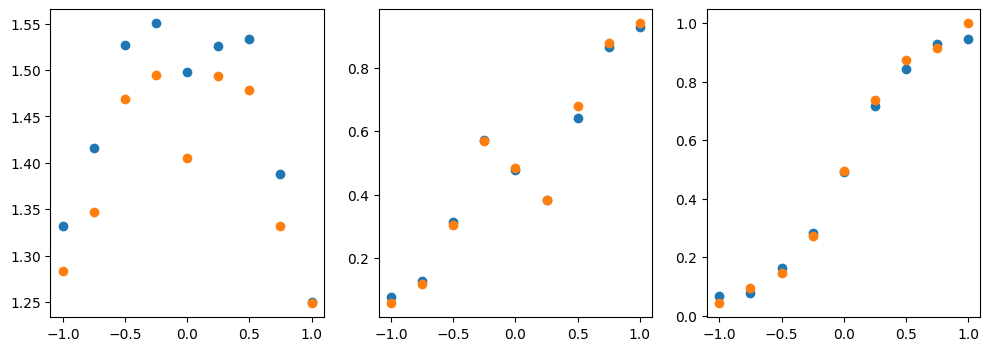

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), y=pred_bhv.groupby(by='value_diff')['rt'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['rt'].mean());

plt.subplot(132)
plt.scatter(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), y=pred_bhv.groupby(by='value_diff')['ch'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['choice'].mean());

plt.subplot(133)
plt.scatter(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(), y=pred_bhv.groupby(by='gaze_diff')['ch'].mean());
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - L)')['choice'].mean());

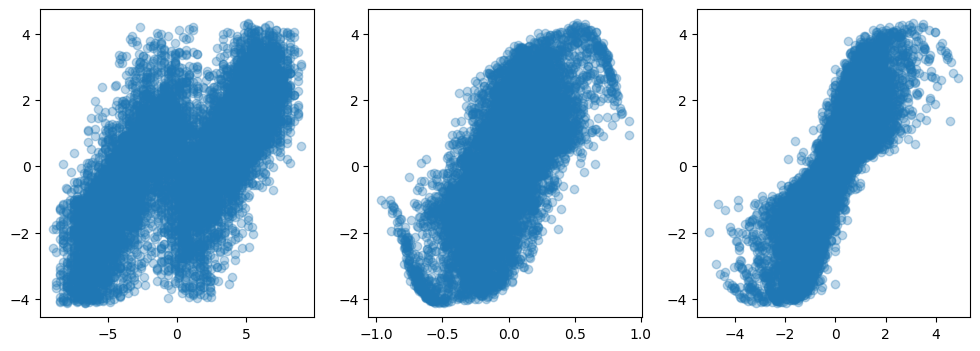

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 0] + X_test[:, 1] - X_test[:, 2] - X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 4] + X_test[:, 5] - X_test[:, 6] - X_test[:, 7], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

plt.subplot(133)
a1 = X_test[:, 0]*X_test[:, 4] +X_test[:, 1]*X_test[:, 5]
a2 = X_test[:, 2]*X_test[:, 6] +X_test[:, 3]*X_test[:, 7]
plt.scatter(a1 - a2, pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

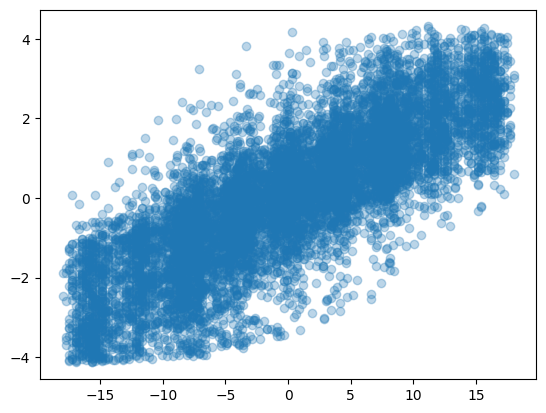

In [13]:
plt.scatter(4*X_test[:, 0] + X_test[:, 1] - 4*X_test[:, 2] - X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);